In [5]:
from tensorflow.keras.layers import Dense, Flatten, Dropout,Input
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,MaxPooling2D,AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam,schedules
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import random
import numpy as np
import os,cv2
import matplotlib
import load_image
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import io
imgH = 32
imgW = 32
TRAIN_SPLIT = 0.85
DIR = "./"

In [6]:
def prepare_image_array(imgDir, imgW, imgH):
    imgList = os.listdir(imgDir)
    # print(imgList)
    n = len(imgList)

    imgSet = []
    for i in range(500):
        imgPath = imgDir + imgList[i]
        if (os.path.exists(imgPath)):
            # print(imgPath)
            img = cv2.imread(imgPath)
            resizedImg = cv2.resize(img, (imgW, imgH))
            rgbImg = cv2.cvtColor(resizedImg, cv2.COLOR_BGR2RGB)
            imgSet.append(rgbImg)
        else:
            print("It is not a valid image path.")

    # print("total image "+str(len(imgSet)))
    imgSet = np.array(imgSet, dtype=np.uint8)
    # print("total shape "+str(imgSet.shape))

    return imgSet


In [7]:
print("runing")
imgDir = DIR + 'Normal/'
imgSet1 = prepare_image_array(imgDir, imgW, imgH)
m = imgSet1.shape[0]

imgDir = DIR + 'OverExposed/'
imgSet2 = prepare_image_array(imgDir, imgW, imgH)
n = imgSet2.shape[0]

imgDir = DIR + 'UnderExposed/'
imgSet3 = prepare_image_array(imgDir, imgW, imgH)
o = imgSet3.shape[0]

# Put all image data into one array.
imgSet = np.concatenate((imgSet1, imgSet2, imgSet3), axis=0)
print(imgSet.shape)

labelSet1 = np.zeros(m, dtype=np.uint8)
labelSet2 = np.ones(n, dtype=np.uint8)
label_o = np.ones(o, dtype=np.uint8)
labelSet3 = np.add(label_o, label_o)
labelSet = np.concatenate((labelSet1, labelSet2, labelSet3), axis=0)


p = imgSet.shape[0]  # p = n + m + o
# indices = np.array(file.read())
# indices = np.arange(p)
# random.shuffle(indices)
# for i in range(len(indices)):
#     file.write(str(indices[i])+",")

# file.close()
f = open('data_index.txt', 'r')
indices = []
for x in f.read().split(','):
    if len(x) > 0:
        num = ''
        for j in x:
            if(j>='0' and j<='9'):
                num +=j;
        if len(num)>0 and int(num)<p:
            indices.append(int(num)) 

# print(indices)
imgSet = imgSet[indices]
labelSet = labelSet[indices]
print(labelSet[:5])
print("Label set : ")
labelSet = labelSet.reshape(p, 1)

#   one hot encoding

labelSet = to_categorical(labelSet)

# print(labelSet[:5])

# print(imgSet[0])
imgSet = imgSet.astype(np.float32)
imgSet = imgSet/255.0

r = int(p * TRAIN_SPLIT)
trainX = imgSet[:r]
trainY = labelSet[:r]
testX = imgSet[r:]
testY = labelSet[r:]



runing
(1500, 32, 32, 3)
[0 0 0 2 2]
Label set : 


In [8]:

DIR = './Large-Size-Convolution-Maxpooling-model/'
modelpath = DIR + 'Large-Size-Convolution-Maxpooling-model.hdf5'
file = open(DIR+'Large-Size.txt',"w")


In [16]:

inputs = Input(shape=(imgH, imgW, 3))
x = Conv2D(filters =128, kernel_size = (3,3),activation='relu', padding="same")(inputs)
x = Conv2D(filters =128, kernel_size = (3,3),activation='relu', padding="same")(x)
x = MaxPooling2D( pool_size=(2, 2), strides=(2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
x = MaxPooling2D( pool_size=(2, 2), strides=(2,2), padding="same")(x)
# x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
# x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
# x = Conv2D(256, (3,3), activation='relu', padding="same")(x)
# x = MaxPooling2D( pool_size=(2, 2), strides=None, padding="same")(x)

# baseModel.summary()
x = Flatten()(x)
x = Dense(units=128, activation="sigmoid")(x)
x = Dropout(.3)(x)
x = Dense(units=32, activation="sigmoid")(x)
# x = Dense(units=64, activation="relu")(x)
# x = Dense(units=8, activation="sigmoid")(x)
outputs = Dense(units=3, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()
model.compile(optimizer="rmsprop",loss='mse',metrics  = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)       590080    
                                                           

In [17]:
import tensorflow as tf
output = []
history_dic = []
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)



  # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

sgd = SGD(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
callbackList = [EarlyStopping(monitor='val_loss', patience=30), History()]
history = model.fit(trainX, trainY, epochs=50, batch_size=128, validation_split=0.2, callbacks=callbackList)

model.save(modelpath)

loss, accuracy = model.evaluate(testX, testY)
print('Accuracy: {}'.format(accuracy))

Epoch 1/50
8/8 [==============================] - 22s 3s/step - loss: 1.1555 - accuracy: 0.3402 - val_loss: 1.1471 - val_accuracy: 0.2980
Epoch 2/50
8/8 [==============================] - 20s 2s/step - loss: 1.1325 - accuracy: 0.3402 - val_loss: 1.1258 - val_accuracy: 0.2980
Epoch 3/50
8/8 [==============================] - 20s 2s/step - loss: 1.1160 - accuracy: 0.3412 - val_loss: 1.1136 - val_accuracy: 0.2980
Epoch 4/50
8/8 [==============================] - 21s 3s/step - loss: 1.1076 - accuracy: 0.3343 - val_loss: 1.1061 - val_accuracy: 0.2980
Epoch 5/50
8/8 [==============================] - 20s 3s/step - loss: 1.1032 - accuracy: 0.3480 - val_loss: 1.1018 - val_accuracy: 0.2980
Epoch 6/50
8/8 [==============================] - 20s 3s/step - loss: 1.1020 - accuracy: 0.3294 - val_loss: 1.0989 - val_accuracy: 0.2980
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 1.1040 - accuracy: 0.3363 - val_loss: 1.0971 - val_accuracy: 0.2980
Epoch 8/50
8/8 [==================

In [11]:
loss, accuracy = model.evaluate(testX, testY)
print('Accuracy: {}'.format(accuracy))

8/8 [==============================] - 0s 53ms/step - loss: 0.9331 - accuracy: 0.6400
Accuracy: 0.6399999856948853


In [15]:
predicted_output = []
prediction = model.predict(testX)
for i in prediction:
    predicted_output.append(np.argmax(i)) 

actual_output = []
for i in testY:
    actual_output.append(np.argmax(i)) 
con_mat = confusion_matrix(actual_output, predicted_output)
for i in con_mat:
    print(i)
    file.write(str(i)+"\n")


[15 48 16]
[ 1 61  1]
[11  4 68]


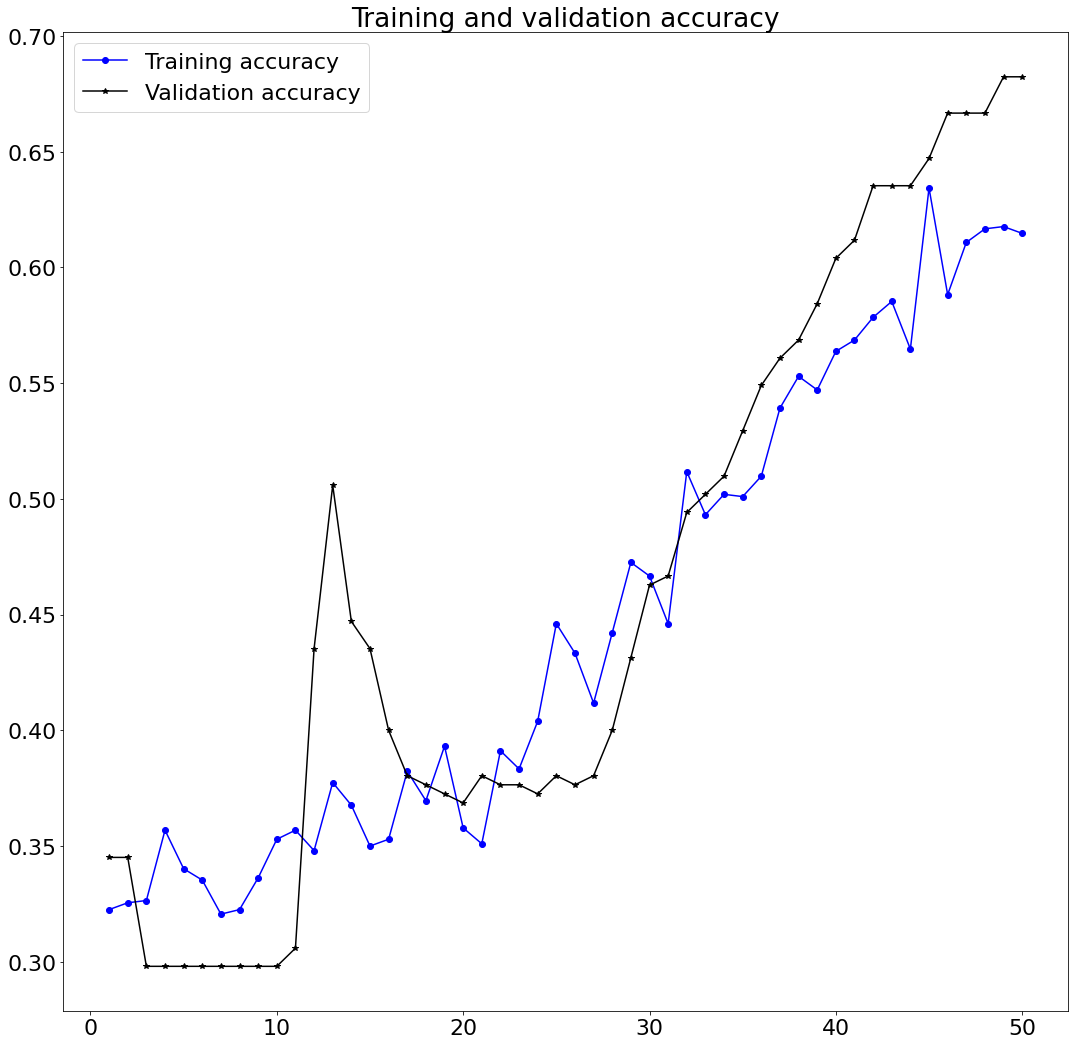

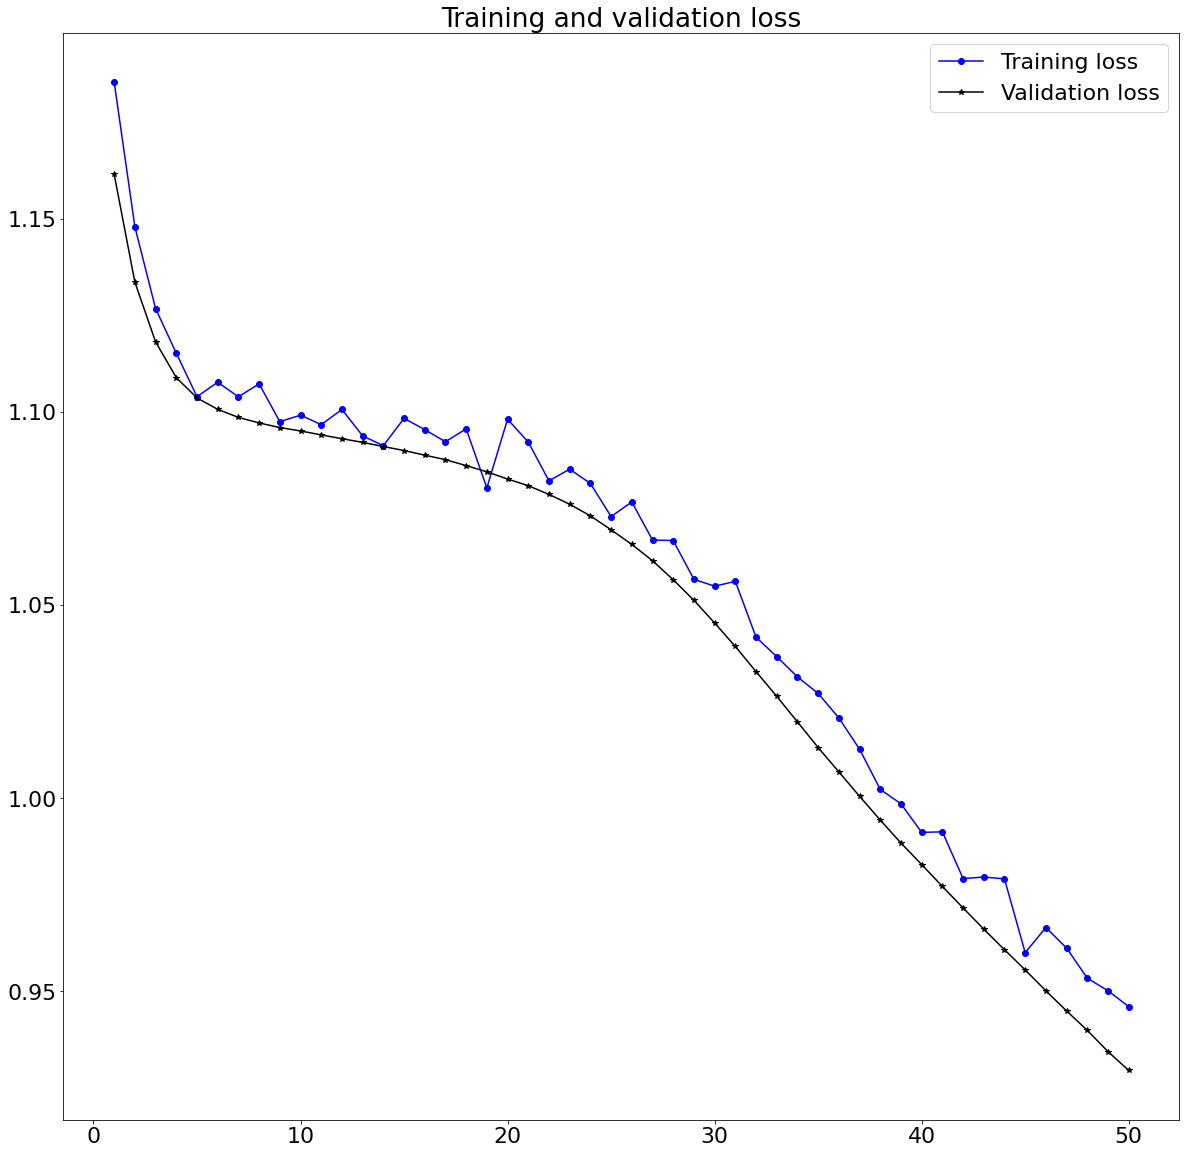

In [13]:
def plot_loss_acc(history):
    accuracy = history.history['accuracy']
    valaccuracy = history.history['val_accuracy']
    epochs = range(1, len(accuracy) + 1)
    plt.figure(figsize=(18, 18))
    plt.rcParams['font.size'] = '22'
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, valaccuracy, 'k*-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig(DIR + 'Large_CNN_training_validation_accuracy.png')
    plt.show()
    plt.close()
    
    loss = history.history['loss']
    valLoss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(20, 20))
    plt.rcParams['font.size'] = '22'
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, valLoss, 'k*-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    plt.savefig(DIR + 'Large_CNN_training_validation_loss.png')
    plt.close()
    
plot_loss_acc(history)